In [ ]:
from modules.models import KdVBurgersPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_kdvburgers
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [1]:
! git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git config --global user.name "Nadia Aiaseh"
!git config --global user.email "naiaseh@uwo.ca"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


### Initial and boundary conditions

### Small-amplitude KdV-B soliton from [Xenos, M. A., & Felias, A. C. (2021). Nonlinear dynamics of the KdV-B equation and its biomedical applications. Nonlinear Analysis, Differential Equations, and Applications, 765-793.](https://link.springer.com/chapter/10.1007/978-3-030-72563-1_26)
equation 26

In [ ]:
alpha = 0.5
beta = 0.7
gamma = 1.
c0 = 1.
k = 0.001
phi = 2*k/gamma * 2 * (alpha + 2*beta*k)
c = c0
ampl = 2*k/gamma * (alpha + 6*beta*k)
phi = phi

# ### shock profile initial condition ###
# def phi_function(tx):
#     offset =  0.
#     ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
#     u = 3/25 * (alpha**2)/(beta*gamma) * (1/tf.cosh(k*ksi)**2 - 2*tf.tanh(k*ksi) - 2)
#     # u = tf.where(tf.math.is_nan(u), 0., u)
#     # u = tf.where(tf.math.is_inf(u), 0., u)
#     return u

def phi_function(tx):
    offset =  0.
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = 2*k/gamma *(2 * (alpha + 2*beta*k) + (alpha + 6*beta*k) * 1/tf.cosh(k*ksi)**2 )

    # u = tf.where(tf.math.is_nan(u), 0., u)
    # u = tf.where(tf.math.is_inf(u), 0., u)
    return u

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])


x_start =  -5000.
length = 5000.
t0 = 0.
time = 10.


Text(0, 0.5, 'u(x,t)')

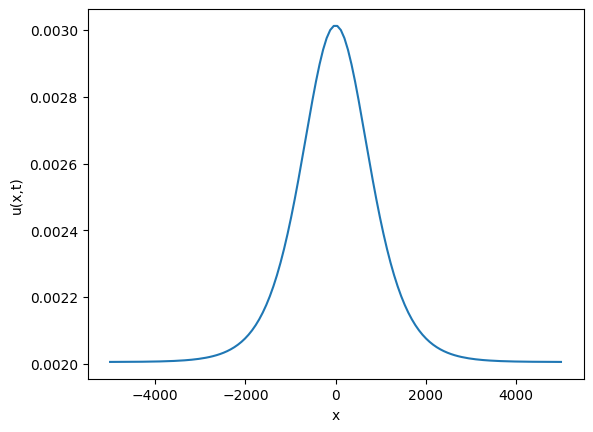

In [ ]:

N =  128
TIME = 0.
xt = np.linspace(x_start,length,N).T

tt = np.zeros((N,1))
xt = xt.reshape(-1,1)

tt = tt.reshape(-1,1)
txy2 = np.stack([np.full(tt.shape, TIME),  xt ], axis=1)
txy3 = np.stack([np.full(tt.shape, time),  xt ], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])

u3 = phi_function(txy3)
u3 = tf.reshape(u3, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2)

plt.xlabel('x')
plt.ylabel('u(x,t)')


### Data generation

In [ ]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdvburgers(30_000, phi_function, boundary_function, x_start, length, t0, time, n_init = None, n_bnd = None, random_seed = 42, dtype=tf.float32)




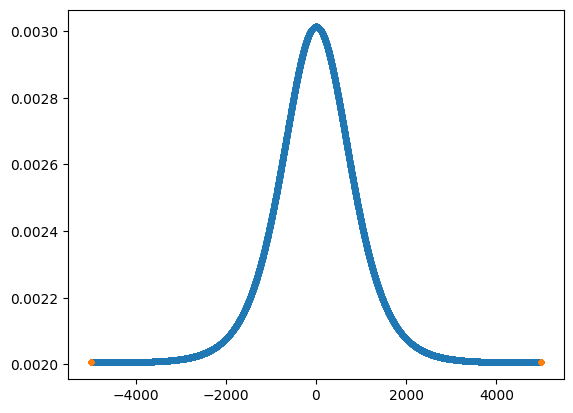

In [ ]:

plt.plot( tx_init[:,1:], phi_function(tx_init),'.')
plt.plot( tx_boundary[:,1:], y_boundary,'.')


In [ ]:
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


### PINN init and training

In [ ]:
backbone = create_dense_model([32, 32, 32], activation='tanh', initializer='glorot_normal',\
    n_inputs=2, n_outputs=1)
pinn = KdVBurgersPinn(backbone, alpha=alpha, beta=beta, gamma=gamma,c=0., loss_residual_weight = 1.)
a0 = 1e-3
decay_step = 1000
rate = 0.95
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(a0, decay_steps= decay_step, decay_rate= rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:

history = pinn.fit_custom(inputs, outputs, epochs = 50_000, print_every = 500)


Epoch 0, Loss Residual: 0.0000301100, Loss Initial: 0.1189735830, Loss Boundary: 0.1217489764, MAE: 0.3442519903
Epoch 500, Loss Residual: 0.0000003133, Loss Initial: 0.0000001176, Loss Boundary: 0.0000000068, MAE: 0.0004423227
Epoch 1000, Loss Residual: 0.0000001223, Loss Initial: 0.0000000865, Loss Boundary: 0.0000000067, MAE: 0.0003167941
Epoch 1500, Loss Residual: 0.0000000414, Loss Initial: 0.0000002658, Loss Boundary: 0.0000001781, MAE: 0.0005133306
Epoch 2000, Loss Residual: 0.0000000199, Loss Initial: 0.0000000890, Loss Boundary: 0.0000000065, MAE: 0.0002109584
Epoch 2500, Loss Residual: 0.0000000145, Loss Initial: 0.0000000747, Loss Boundary: 0.0000000066, MAE: 0.0002155292
Epoch 3000, Loss Residual: 0.0000000098, Loss Initial: 0.0000033237, Loss Boundary: 0.0000032513, MAE: 0.0018196865
Epoch 3500, Loss Residual: 0.0000000069, Loss Initial: 0.0000000837, Loss Boundary: 0.0000000062, MAE: 0.0002083647
Epoch 4000, Loss Residual: 0.0000000063, Loss Initial: 0.0000001104, Loss Bo

### Plots

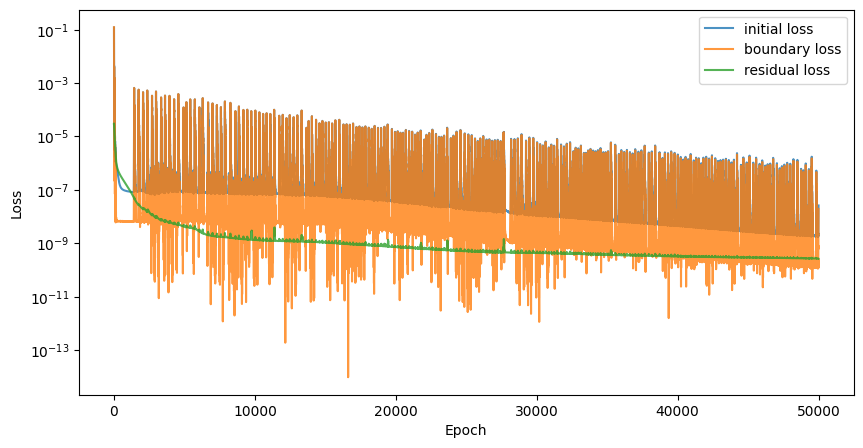

In [ ]:
 history2 = {k: history[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary')}

plot_training_loss(history2, y_scale='log')



Text(0, 0.5, 'MAE')

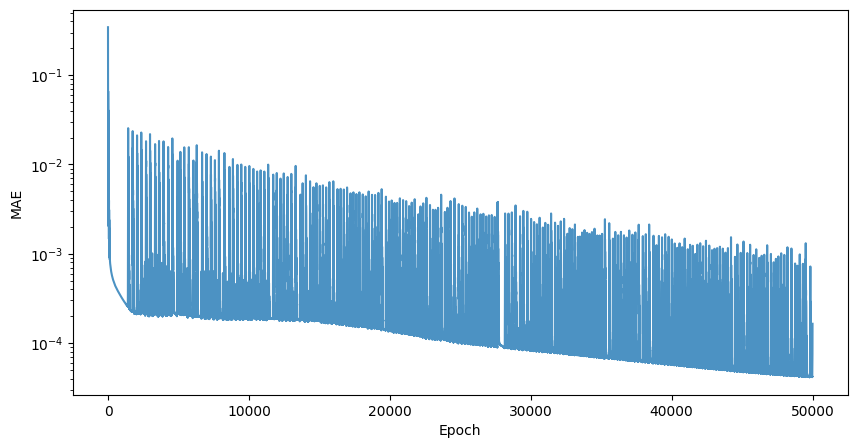

In [ ]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(history['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')

1/1 [==============================] - 0s 18ms/step


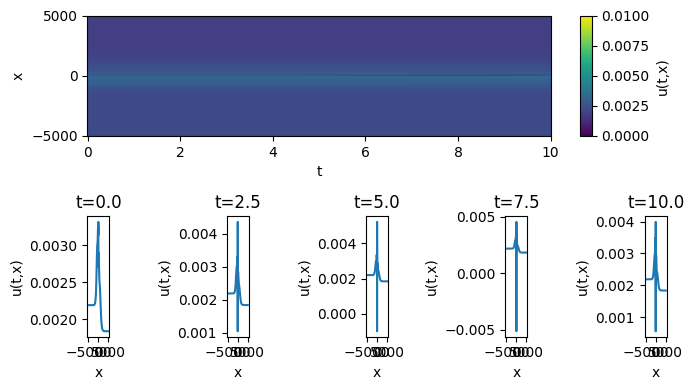

In [ ]:
plot_KdV_model(pinn.backbone, x_start,length, time, 0, 0.01, t0 = t0, save_path = None, show=True)

1000/1000 [==============================] - 1s 1ms/step


Text(0, 0.5, '$t$')

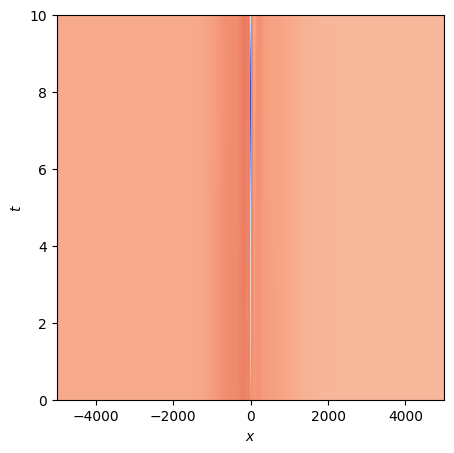

In [ ]:
    from matplotlib.gridspec import GridSpec

    num_test_samples = 1000
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1) #
    u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1, 1)
    plt.subplot(gs[:, :])
    plt.pcolormesh(x, t, u, cmap = 'coolwarm', shading='auto')
    plt.xlabel('$x$')
    plt.ylabel('$t$')


In [ ]:
def plot_snapshots(timeList,num_test_samples = 1000, phi_function = phi_function, pinn = pinn):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))
        plt.plot(x_flat, phi_function(tx),label = 'analytical at time {}'.format(t_cs))
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('u(t,x)')

    return

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
xspace = np.linspace(x_start, length, N + 1)
tspace = np.linspace(t0, time, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)

upred = pinn.backbone.predict(Xgrid)

# Reshape upred
U = upred.reshape(N+1,N+1)

# Surface plot of solution u(t,x)

31313/31313 [==============================] - 37s 1ms/step


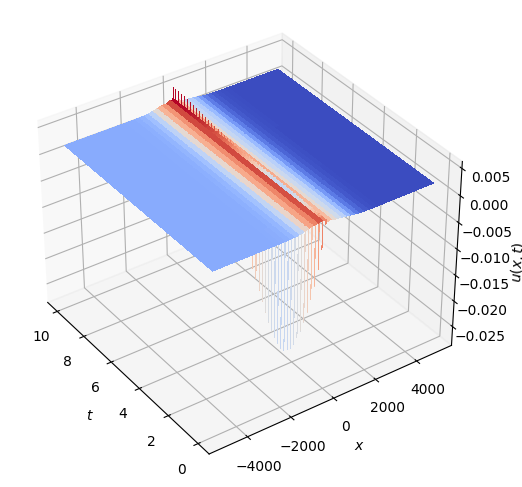

In [ ]:
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(T, X, U, cmap='coolwarm', antialiased = False, linewidth=0);
ax.view_init(35,-35,0)
# ax.view_init(90,-90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(x,t)$')
ax.invert_xaxis()
# ax.set_title('Solution of KdV equation');

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(1))

(1000, 2)
1/1 [==============================] - 0s 22ms/step
(1000, 2)
1/1 [==============================] - 0s 20ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step


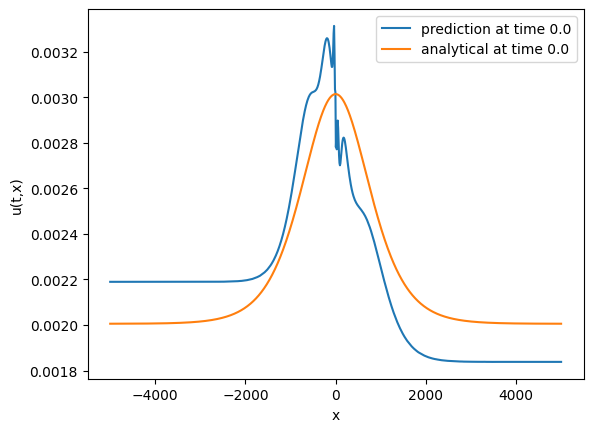

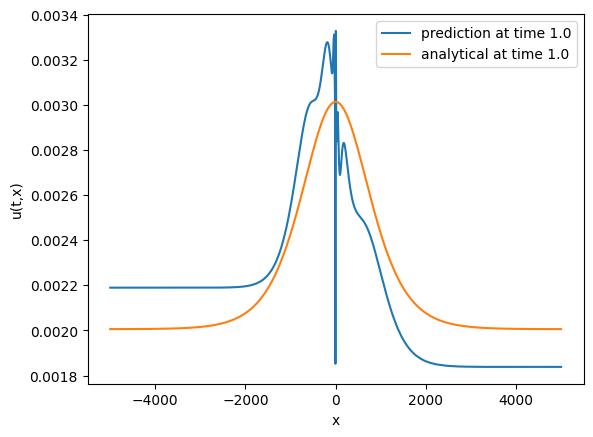

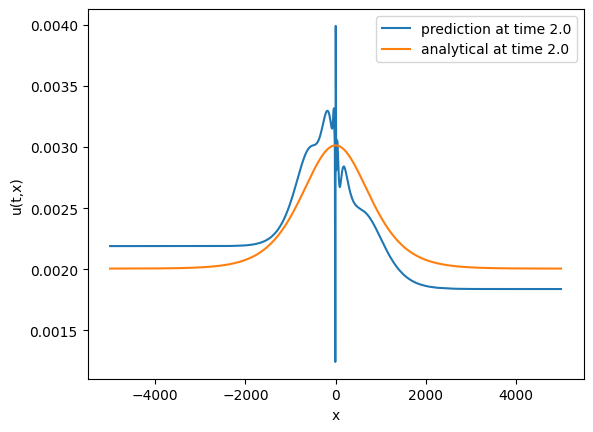

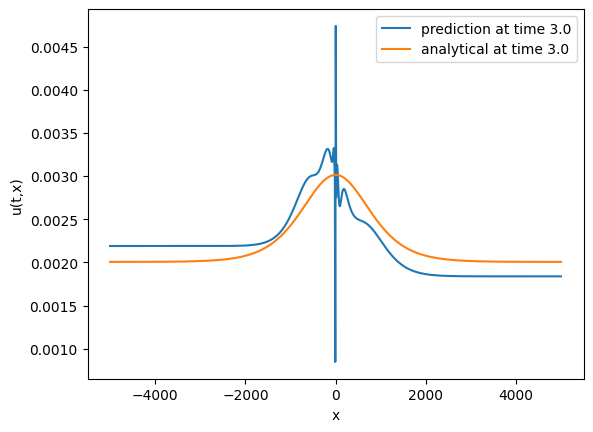

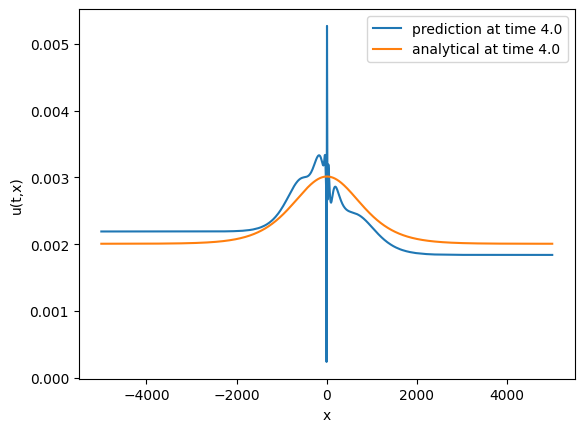

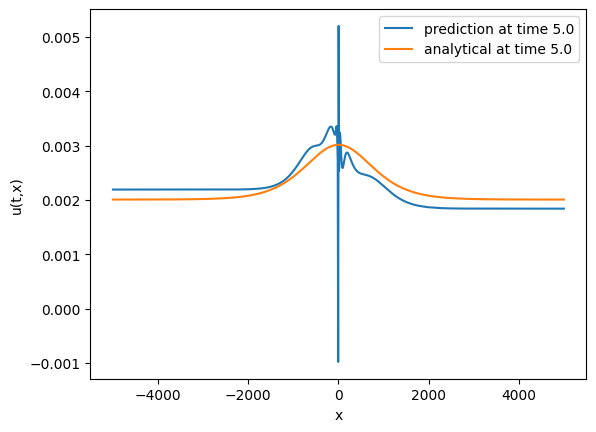

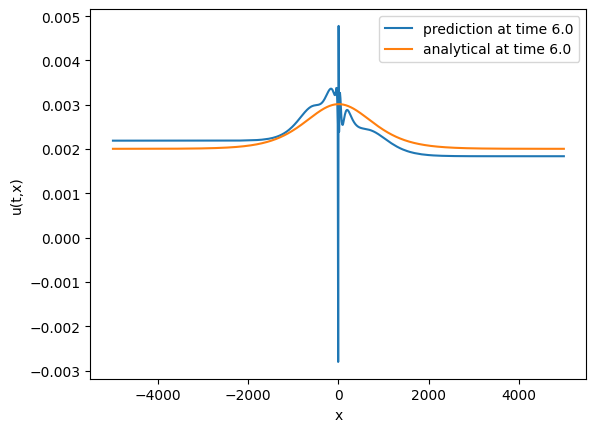

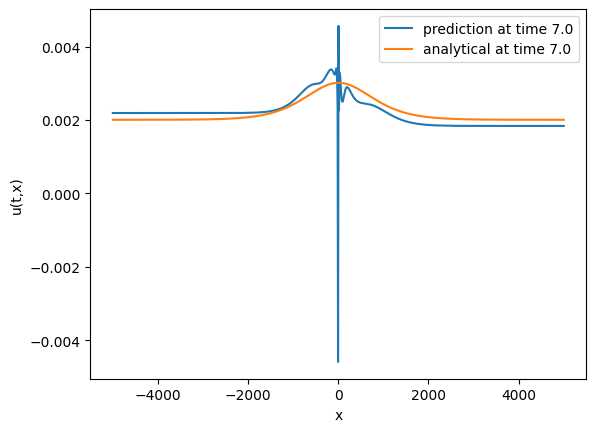

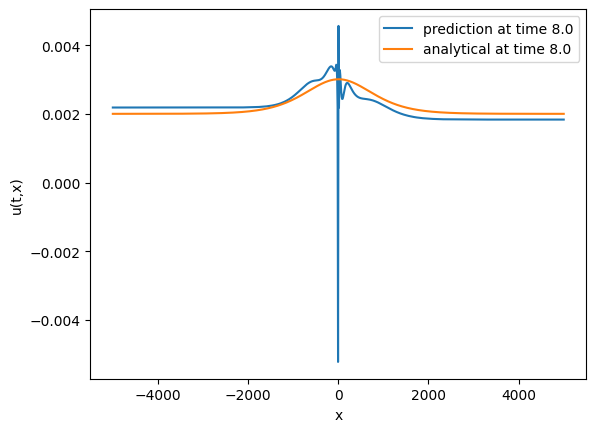

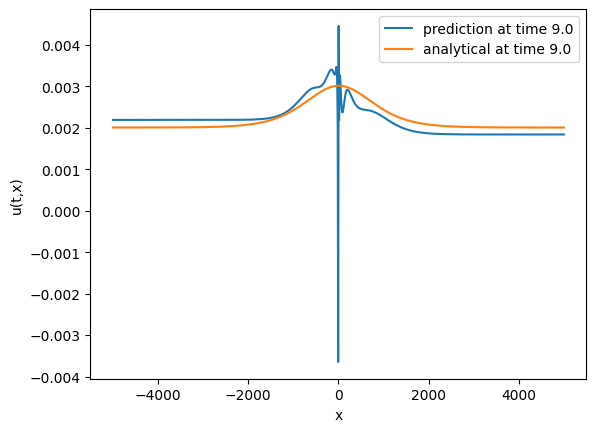

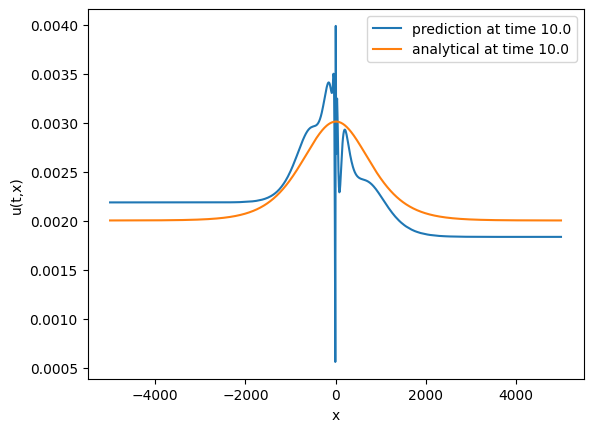

In [ ]:
step = 1
T = np.arange(t0,time+step, step)
for inde, Tt in enumerate(T):
  plt.figure()
  plot_snapshots([Tt], phi_function = phi_function, pinn = pinn)
  # plt.ylim([-0.5, 2.3])
  # plt.xlim([-50,50])
  # plt.savefig(str(os.getcwdb())[2:-1]+"/FinalPictures/KdVBTwoSolitonAlpha0-1/fr"+str(inde)+".pdf", format="pdf", bbox_inches="tight")